In [1]:
# essentials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
from collections import Counter
import pickle

# NLP
import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout

# train test split 
from sklearn.model_selection import train_test_split

# my files
import config
from utils import DataGenerator

In [2]:
small_data = True
seed = 42
input_size = config.INPUT_SIZE

In [3]:
try:
    os.makedirs(config.NN_MODEL_DIR)
except(FileExistsError):
    print(f"WARNING: You will may overwrite your models, because directory \"{config.NN_MODEL_DIR}\" already exists.")

## Load the data

In [4]:
if small_data:
    data_path = "data/reviews_cleaned_sample.csv"
    vocabulary_filename = "vocabulary_small.pkl"
else:
    data_path = "data/reviews_cleaned.csv"
    vocabulary_filename = "vocabulary.pkl"

reviews_df = pd.read_csv(data_path, converters={'tokenized': pd.eval})

Since I am using the whole dataset to create word2vec I can use the same one every time, regardless to the sample I take to train the NN

In [5]:
with open("models/word2vec-general.pkl", "rb") as file:
    word2vec = pickle.load(file)

### Generating vocabulary

In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjasi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
all_words = []

for tokenized_reviews in reviews_df.tokenized:
    all_words.extend(tokenized_reviews)

In [8]:
vocabulary = [word for word, quantity in Counter(all_words).items() if quantity >= config.VOCAB_MIN_COUNT]
vocabulary.append(config.END_TOKEN)

In [9]:
vocabulary_size = len(vocabulary)
vocabulary_size

1046

In [10]:
with open(os.path.join(config.NN_MODEL_DIR, vocabulary_filename), 'wb') as file:
    pickle.dump(vocabulary, file)

### Filtering tokens

In [11]:
# function to which filter token basing on the vocabulary

## NOT USE!

# def filter_tokens(tokens, remove_stopwords=False):
#     # removing rarely occurring words (< min_count)
#     tokens = [token for token in tokens if token in vocabulary]

#     if remove_stopwords:
#         tokens = [token for token in tokens if token not in stop_words]

#     # and adding [END] of document token at the end  
#     tokens.append(config.END_TOKEN)

#     return tokens

In [12]:
# reviews_df["filter_tokens"] = reviews_df.tokenized.apply(filter_tokens)

## Creating the dataset

In [13]:
word2vec.wv.similar_by_word("movie")

[('film', 0.8467691540718079),
 ('flick', 0.6801257133483887),
 ('show', 0.5999926328659058),
 ('sequel', 0.5885446071624756),
 ('it', 0.5882192254066467),
 ('crap', 0.5746539235115051),
 ('documentary', 0.5344873070716858),
 ('movies', 0.5193456411361694),
 ('mess', 0.5141649842262268),
 ('picture', 0.5118617415428162)]

In [14]:
X_words = []
y_words = []

for tokenized_review in reviews_df.tokenized:
    # iterating over indices for the first which has enough words before (PREVIOUS_WORDS_CONSIDERED)
    # until the last one
    for index in range(config.PREVIOUS_WORDS_CONSIDERED, len(tokenized_review)): 
        x = tokenized_review[index-config.PREVIOUS_WORDS_CONSIDERED: index]
        y = tokenized_review[index]

        # only from token in vocabulary
        if y in vocabulary:
            if all(xx in vocabulary for xx in x):
                print(x, y)
                X_words.append(tokenized_review[index-config.PREVIOUS_WORDS_CONSIDERED: index])
                y_words.append(tokenized_review[index])

['work', 'of', 'art'] and
['of', 'art', 'and'] probably
['art', 'and', 'probably'] my
['and', 'probably', 'my'] number
['probably', 'my', 'number'] one
['and', 'not', 'to'] be
['this', 'is', 'an'] intelligent
['is', 'an', 'intelligent'] and
['and', '\x96', 'surprise'] 
['\x96', 'surprise', '\x96'] pretty
['this', 'is', 'more'] than
['is', 'more', 'than'] just
['violence', 'and', 'its'] about
['and', 'its', 'about'] time
['its', 'about', 'time'] those
['is', 'a', 'beautiful'] th
['forced', 'to', 'live'] the
['to', 'live', 'the'] life
['live', 'the', 'life'] of
['the', 'life', 'of'] an
['just', 'because', 'shes'] female
['because', 'shes', 'female'] and
['shes', 'female', 'and'] she
['about', 'this', 'after'] a
['to', 'believe', 'that'] director
['so', 'realistic', 'and'] so
['realistic', 'and', 'so'] disturbing
['and', 'so', 'disturbing'] i
['you', 'to', 'come'] up
['to', 'come', 'up'] with
['come', 'up', 'with'] a
['up', 'with', 'a'] title
['with', 'a', 'title'] that
['actually', 'as'

In [15]:
len(X_words)

78832

## Word embedding

In [16]:
label_to_index = {word: index for index, word in enumerate(vocabulary)}

In [17]:
X = np.zeros((len(X_words), input_size))

for index, x in enumerate(X_words):
    numpy_x = np.array([])
    for word in x:
        numpy_x = np.append(numpy_x, word2vec.wv.get_vector(word))

    X[index, ...]  = numpy_x

In [18]:
y = np.zeros((len(y_words), vocabulary_size))

for index, label in enumerate(y_words):
    y[index, label_to_index[label]] += 1

In [19]:
data_generator = DataGenerator.DataGenerator(reviews_df.tokenized)

In [20]:
data_generator.create_vocabulary(min_count=config.VOCAB_MIN_COUNT, extra_tokens=[config.END_TOKEN])

In [21]:
X_words, y_words = data_generator.create_dataset(previous_words_considered=config.PREVIOUS_WORDS_CONSIDERED)

In [22]:
X = data_generator.vectorize(X_words, y_words, word_vectorizer=word2vec, input_size=config.INPUT_SIZE)

In [ ]:
label_to_index = {word: index for index, word in enumerate(self.vocabulary)}

In [ ]:
y = np.zeros((len(y_words), len(data_generator.vocabulary)))

for index, label in enumerate(y_words):
    y[index, label_to_index[label]] += 1

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=seed)

## Dense NN model

In [29]:
model = Sequential()

model.add(Input(config.INPUT_SIZE))
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))


model.add(Dense(vocabulary_size, activation="sigmoid"))

model.build()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              615424    
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                                 
 dense_9 (Dense)             (None, 1046)             

In [30]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=config.LABEL_SMOOTHING_RATIO)
optimizer = tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)

In [31]:
model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])

In [35]:
# patience and start_from_epochs depending on the epochs number
# patience 10% of the total number of epochs
# start_from_epochs 5% of the total number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=int(config.EPOCHS/10), 
                                                start_from_epoch=(config.EPOCHS/20),
                                                min_delta=0.001,
                                                restore_best_weights=True,
                                                verbose=1) 

In [33]:
training = model.fit(X_train, y_train, validation_split=0.1, batch_size=config.BATCH_SIZE, epochs=config.EPOCHS, callbacks=[early_stopping])

Epoch 1/64
499/499 [==============================] - 12s 23ms/step - loss: 6.1180 - acc: 0.0707 - val_loss: 5.9622 - val_acc: 0.1084
Epoch 2/64
499/499 [==============================] - 12s 24ms/step - loss: 5.8394 - acc: 0.1116 - val_loss: 5.7443 - val_acc: 0.1336
Epoch 3/64
499/499 [==============================] - 13s 26ms/step - loss: 5.6738 - acc: 0.1302 - val_loss: 5.5839 - val_acc: 0.1412
Epoch 4/64
499/499 [==============================] - 13s 25ms/step - loss: 5.5641 - acc: 0.1401 - val_loss: 5.5122 - val_acc: 0.1476
Epoch 5/64
499/499 [==============================] - 13s 25ms/step - loss: 5.4886 - acc: 0.1476 - val_loss: 5.4550 - val_acc: 0.1552
Epoch 6/64
499/499 [==============================] - 13s 26ms/step - loss: 5.4272 - acc: 0.1538 - val_loss: 5.4209 - val_acc: 0.1567
Epoch 7/64
499/499 [==============================] - 13s 27ms/step - loss: 5.3813 - acc: 0.1589 - val_loss: 5.3812 - val_acc: 0.1612
Epoch 8/64
499/499 [==============================] - 13s 26ms

In [36]:
loss, acc = model.evaluate(X_test, y_test)

247/247 [==============================] - 1s 4ms/step - loss: 5.2352 - acc: 0.1834


In [37]:
acc = "{:.2f}".format(acc)
model_filename = f"dense-lr{config.LEARNING_RATE}-batch{config.BATCH_SIZE}-acc{acc}.h5"

model.save(os.path.join(config.NN_MODEL_DIR, model_filename))

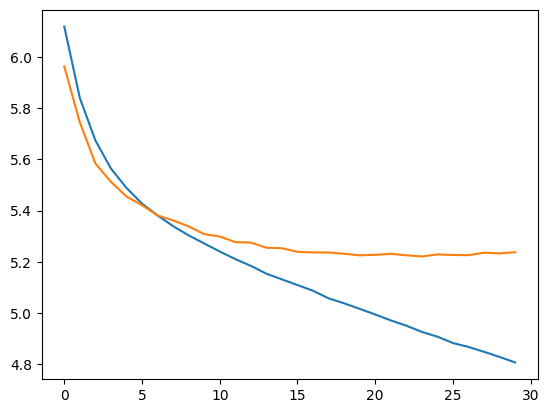

In [38]:
# due to early stopping executed epochs might be different
executed_epochs = len(training.history["loss"])

plt.plot(range(executed_epochs), training.history["loss"])
plt.plot(range(executed_epochs), training.history["val_loss"])